In [2]:
import jax.numpy as jnp
from matplotlib import pyplot as plt
from scipy.linalg import eig_banded
import jax
from jax import jit
from tqdm import tqdm
from jax.scipy.optimize import minimize
from jaxopt import LBFGS
jax.config.update("jax_enable_x64", True)

# first derivative approximation via finite difference for various orders of accuracy

@jit
def d2(phi, dx): 
    pad = jnp.concatenate((jnp.array([0]), phi, jnp.array([0])))
    return (pad[2:] - pad[:-2]) / (2*dx)

@jit
def d4(phi, dx): 
    pad = jnp.concatenate((jnp.array([0,0]), phi, jnp.array([0,0])))
    return ((-1/12)*pad[4:] + (2/3)*pad[3:-1] - (2/3)*pad[1:-3] + (1/12)*pad[:-4])/dx

@jit
def d6(phi, dx): 
    pad = jnp.concatenate((jnp.array([0,0,0]), phi, jnp.array([0,0,0])))
    return ((1/60)*pad[6:] + (-3/20)*pad[5:-1] + (3/4)*pad[4:-2] + 0*pad[3:-3] + (-3/4)*pad[2:-4] + (3/20)*pad[1:-5] + (-1/60)*pad[:-6])/dx

@jit
def d8(phi, dx): 
    pad = jnp.concatenate((jnp.array([0,0,0,0]), phi, jnp.array([0,0,0,0])))
    return ((-1/280)*pad[8:] + (4/105)*pad[7:-1] + (-1/5)*pad[6:-2] + (4/5)*pad[5:-3] + 0*pad[4:-4] + (-4/5)*pad[3:-5] + (1/5)*pad[2:-6] + (-4/105)*pad[1:-7] + (1/280)*pad[:-8])/dx

d = d8

# integration along a axis 0 or 1

@jit
def i0(phi, dx):
    return jnp.trapezoid(phi, dx = dx, axis = 0)

@jit
def i1(phi, dx):
    return jnp.trapezoid(phi, dx = dx, axis = 1)

def get_theta(num_points, num_junction, num_island):
    nx = num_points
    num_pad = (nx - 2 * num_island - num_junction) / 2
    assert(num_pad == int(num_pad))
    num_pad = int(num_pad)
    theta = jnp.concatenate((jnp.zeros(num_pad), jnp.ones(num_island), jnp.zeros(num_junction), jnp.ones(num_island), jnp.zeros(num_pad)))
    return theta

def solve(xmax, num_points, num_junction, num_island, N, initial_guess, **kwargs):
    nx = num_points
    x = jnp.linspace(-xmax, xmax, nx)
    dx = x[1]-x[0]
    X = x.reshape((nx,1))
    absdiff = jnp.abs(X - X.T) 
    num_pad = (nx - 2 * num_island - num_junction) / 2
    assert(num_pad == int(num_pad))
    num_pad = int(num_pad)
    theta = jnp.concatenate((jnp.zeros(num_pad), jnp.ones(num_island), jnp.zeros(num_junction), jnp.ones(num_island), jnp.zeros(num_pad)))

    a = num_island / nx * 2 * xmax
    L = num_junction / nx * 2 * xmax

    U_ext = i1(absdiff * theta.reshape((1,nx)), dx)
    background_energy = -(1/(4*a))*i0(theta*i1(absdiff*theta.reshape(1,nx), dx), dx) # energy contributed by jellium background

    """
    # alternative analyical definition of U_ext and background energy
    x_abs = jnp.abs(x)
    region1 = a * (a + L)
    region2 = a * (a + L) + 0.25 * (L - 2 * x_abs)**2
    region3 = 2 * a * x_abs
    U_ext = jnp.where(
        x_abs < L/2, 
        region1,
        jnp.where(
            x_abs <= L/2 + a, 
            region2,
            region3
        )
    )
    background_energy = -(a/6)*(4*a+3*L)
    """

    @jit
    def eps(phi):
        return i0(4*d(phi, dx)**2 + U_ext*phi**2, dx)

    @jit
    def U(phi_i, phi_j, phi_k, phi_l):
        left  = (phi_i*phi_l)
        right = (phi_j*phi_k).reshape(1,nx) 
        return -(a/N) * i0(left*i1(absdiff*right, dx), dx)

    @jit
    def alpha(phi):
        return U(phi, phi, phi, phi)

    @jit
    def beta(phi_p, phi_m):
        return U(phi_p, phi_m, phi_m, phi_p)

    @jit
    def gamma(phi_p, phi_m):
        return U(phi_p, phi_m, phi_p, phi_m)

    @jit
    def unpack(phis_c):
        phi_p, phi_m, c = phis_c[:nx//2], phis_c[nx//2:nx], phis_c[nx:]
        phi_p = jnp.concatenate((jnp.flip(phi_p), phi_p))
        phi_m = jnp.concatenate((-jnp.flip(phi_m), phi_m))
        phi_p = phi_p / jnp.sqrt(i0(phi_p**2, dx))
        phi_m = phi_m / jnp.sqrt(i0(phi_m**2, dx))
        c = c / jnp.sqrt(jnp.sum(c**2))
        return phi_p, phi_m, c

    S = N / 2
    m = jnp.arange(-S, S + 1)
    coeff_plus  = jnp.sqrt(S*(S+1) - m*(m-1))  # S+
    coeff_minus = jnp.sqrt(S*(S+1) - m*(m+1))  # S-

    @jit
    def Sz(c):
        return m*c
    
    @jit
    def Sx(c):
        c_plus  = jnp.concatenate([jnp.array([0.0]), c[:-1]])  # c_{m-1}
        c_minus = jnp.concatenate([c[1:], jnp.array([0.0])])  # c_{m+1}
        return 0.5 * (coeff_plus * c_plus + coeff_minus * c_minus)

    # total energy per particle
    @jit
    def H(phis_c):
        phi_p, phi_m, c = unpack(phis_c)
        Eps_p = eps(phi_p)
        Eps_m = eps(phi_m)
        Alpha_p = alpha(phi_p)
        Alpha_m = alpha(phi_m)
        Beta = beta(phi_p, phi_m)
        Gamma = gamma(phi_p, phi_m)
        E0 = ((Eps_p + Eps_m)/2 + (N/2-1)*(Alpha_p + Alpha_m)/2 + (N/2)*Beta - Gamma)

        z1 = 0
        z2 = 4*Gamma/N
        x1 = (Eps_p - Eps_m + (N-1)*(Alpha_p - Alpha_m))/N
        x2 = (Alpha_p + Alpha_m - 2*Beta)/N

        Sx_c = Sx(c)
        Sx2_c = Sx(Sx_c)
        Sz_c = Sz(c)
        Sz2_c = Sz(Sz_c)

        return E0 + jnp.dot(c, x1*Sx_c + x2*Sx2_c + z1*Sz_c + z2*Sz2_c) + background_energy
    
    """"
    # helper function to find the Sx2 minimizing c vector
    @jit
    def Sx2_objective(c):
        c /= jnp.sqrt(jnp.sum(c**2))
        Sx_c = Sx(c)
        Sx2_c = Sx(Sx_c)
        return jnp.dot(c, Sx2_c)
    """ 
    solver = LBFGS(fun=H, **kwargs)
    result = solver.run(initial_guess)
    assert(result.state.error < solver.tol)
    phi_p, phi_m, c = unpack(result.params)
    return phi_p, phi_m, c, result.state.value

In [3]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import matplotlib as mpl

def run(forward = True):
    # define parameters
    N = 200
    xmax = 100
    num_points = 1000
    num_island = 100 # number of island points
    num_junction_list = jnp.arange(0, 200, 10)
    #num_junction_list = jnp.flip(num_junction_list)
    Ls = num_junction_list / num_points * 2 * xmax

    # prepare figure
    cmap = plt.get_cmap('viridis', len(Ls))
    fig, axs = plt.subplots(2, 2, figsize=(7,7))
    axs[0][0].set_xlim(-xmax, xmax)
    axs[0][1].set_xlim(-xmax,xmax)
    axs[1][1].set_xlim(Ls.min(), Ls.max())
    axs[0][0].set_xlabel(r'$x/\xi$')
    axs[0][1].set_xlabel(r'$x/\xi$')
    axs[0][0].set_ylabel(r'$\phi_+ [a.u.]$')
    axs[0][1].set_ylabel(r'$\phi_- [a.u.]$')
    axs[1][0].set_xlabel(r'$m$')
    axs[1][0].set_ylabel(r'$\langle m_\mathrm{R}, (N-m)_\mathrm{L} | \Psi \rangle $')
    axs[1][1].set_xlabel('Junction length / ' + r'$\xi$')
    #axs[1][1].set_ylabel(r'$\langle 0_+, N_- | \Psi \ran fgle$')
    axs[1][1].set_ylabel(r'$\langle H \rangle/N$')
    norm = mpl.colors.Normalize(vmin=Ls.min(), vmax=Ls.max())
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=axs[-1][-1],                 # <-- correct axis
        orientation='horizontal',
        pad=0.2
    )
    cbar.set_label("Junction length / " + r"$\xi$")
    plt.tight_layout()

    # initialize optimization arrays
    coefficients = []
    left_modes = []
    right_modes = []
    energies = []
    energies = jnp.zeros(len(num_junction_list))
    maxiter = 50000
    tol = 1e-8
    verbose = False

    if forward:
        theta = get_theta(num_points, num_junction_list[0], num_island)
        initial_guess = jnp.concatenate((theta[num_points//2:], theta[num_points//2:], jnp.ones(N+1)))
        iterator = range(len(num_junction_list))
    else:
        theta = get_theta(num_points, num_junction_list[-1], num_island)
        initial_guess = jnp.concatenate((theta[num_points//2:], theta[num_points//2:], jnp.zeros(N//2), jnp.ones(1), jnp.zeros(N//2)))
        iterator = range(len(num_junction_list)-1, -1, -1)
        
    for i in iterator:
        num_junction = num_junction_list[i]
        phi_p, phi_m, c, energy = solve(xmax, num_points, num_junction, num_island, N, initial_guess, maxiter = maxiter, tol = tol, verbose = verbose)
        phi_R, phi_L = (phi_p + phi_m)/jnp.sqrt(2), (phi_p - phi_m)/jnp.sqrt(2)
        phi_R *= jnp.sign(phi_R[jnp.argmax(jnp.abs(phi_R))])
        phi_L *= jnp.sign(phi_L[jnp.argmax(jnp.abs(phi_L))])
        coefficients.append(c)
        left_modes.append(phi_L)
        right_modes.append(phi_R)
        energies = energies.at[i].set(energy)
        #energies.append(energy)

        nx = num_points
        L = Ls[i]   
        initial_guess = jnp.concatenate((phi_p[nx//2:], phi_m[nx//2:], c))

        axs[0][0].plot(jnp.linspace(-xmax, xmax, num_points), (phi_R + phi_L)/jnp.sqrt(2), color=cmap(i))
        axs[0][1].plot(jnp.linspace(-xmax, xmax, num_points), (phi_R - phi_L)/jnp.sqrt(2), color=cmap(i))
        axs[1][0].scatter(jnp.arange(0, N + 1), c.reshape(len(c)), color=cmap(i), alpha = 1)
        #axs[1][0].set_yscale('log')
        #axs[1][0].set_ylim(1e-10, 1)
        #axs[1][0].set_xlim(N//2-10,N//2+10)
        axs[1][1].scatter(Ls[i], energy, color = cmap(i))
        clear_output()
        display(fig)
    return jnp.array(energies)

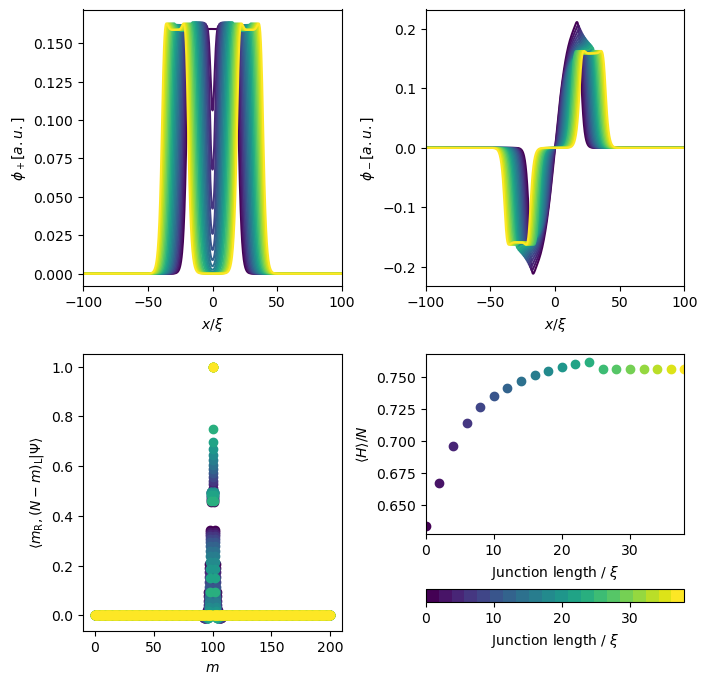

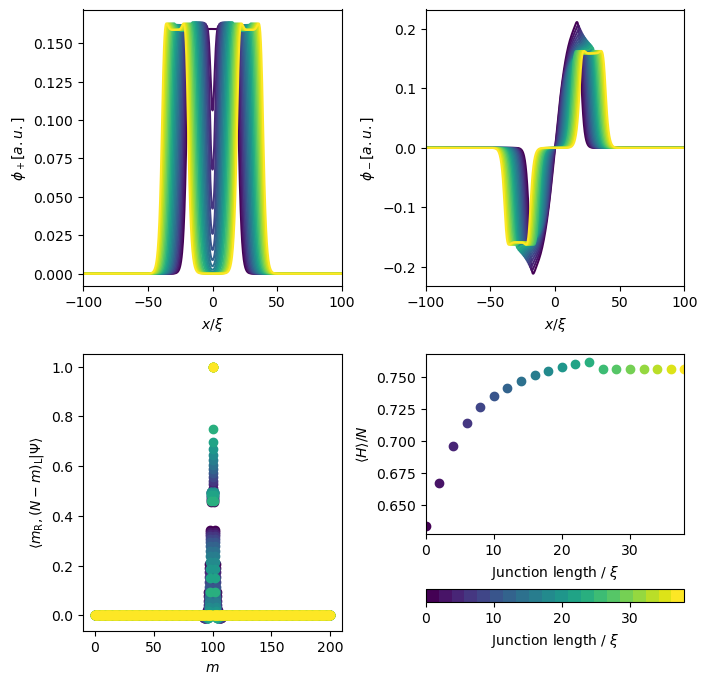

In [4]:
forward_energies = run(forward = True)

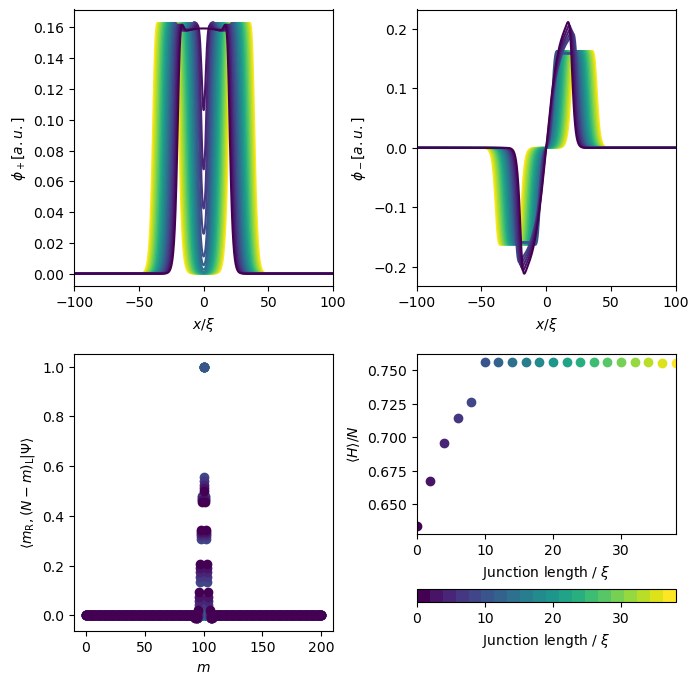

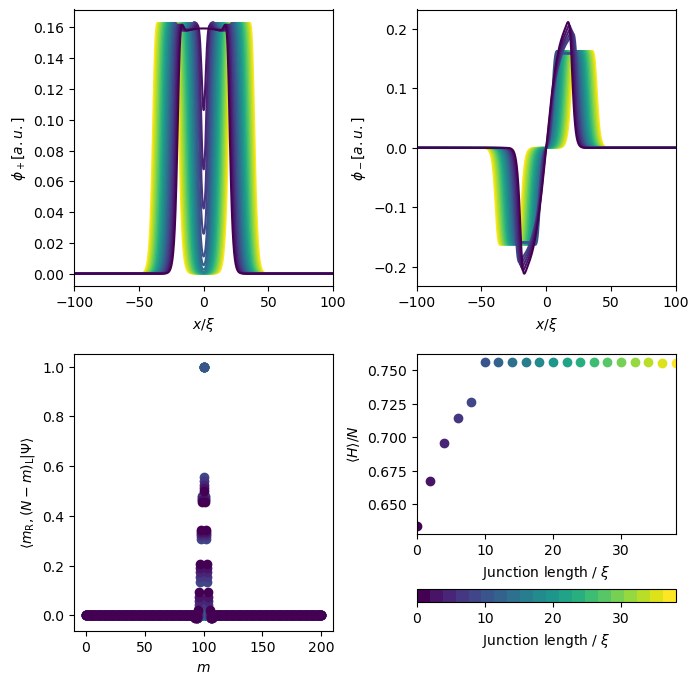

In [17]:
backward_energies = run(forward = False)

[0.63370343 0.66704525 0.69585782 0.71413621 0.72616823 0.73478495
 0.74137688 0.74662441 0.75088656 0.7543714  0.75720879 0.7594773
 0.76118473 0.7560016  0.75598154 0.75596148 0.75594142 0.75592136
 0.7559013  0.75588124]


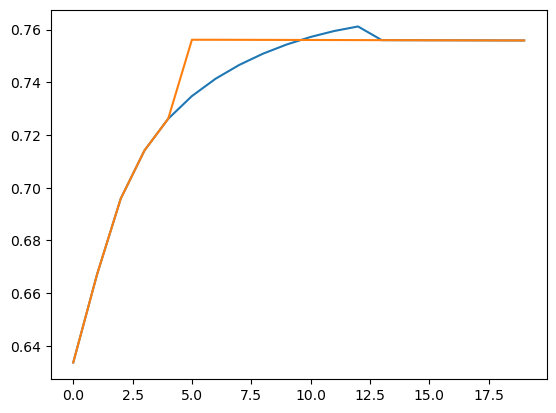

In [18]:
print(forward_energies)
plt.plot(forward_energies)
plt.plot(backward_energies)
plt.show()